# Assignment 6. EDP-2023

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Coding

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Coding, Reviewing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from sklearn.preprocessing import minmax_scale

pd.options.plotting.backend = 'plotly'

pio.templates["standard"] = go.layout.Template(layout=dict(
    title_font_family = 'Courier',
    font_size = 20,
    margin = dict(t=50, b=0, l=50, r=0),
    yaxis_nticks = 4,
    xaxis_nticks = 5,
    legend_title = '',
    legend_font_family = 'Courier',
    legend_orientation = 'v',
    legend_xanchor = 'right',
    legend_bgcolor = 'rgba(256,256,256,0.8)',
    legend_x = 1,
    legend_y = 1.15,
    width = 1150, 
    height = 500)
)
colors = px.colors.qualitative.Plotly
pio.templates.default = 'simple_white+standard'

def state_equation(sample_size: int = 200, X1: float = 5, V1: float = 1, T: float = 1, variance: float = 0.04):
    # initialize values
    a = np.random.normal(0, np.sqrt(variance), sample_size)
    X_vector = np.array([np.zeros(sample_size)] * 2)
    X_vector[:, 0] = np.array([X1, V1])

    # Input matrix
    G = np.array([(T**2) / 2, T])
    # Transition matrix
    F = np.array([[1, T], [0, 1]])
    
    # calculate state equation
    for i in range(1, sample_size):
        X_vector[:, i] = F.dot(X_vector[:, i-1]) + G * a[i]
    
    return X_vector

def measurement_equation(X: np.array, meas_variance: float = 400):
    noise = np.random.normal(0, np.sqrt(meas_variance), int(X.shape[1]))
    # Observation matrix
    H = np.array([1, 0]).T
    Z = np.array(np.zeros(int(X.shape[1])))

    # Calculate measurements
    for i in range(int(X.shape[1])):
        Z[i] = H.dot(X[:, i]) + noise[i]
    return Z

def Kalman_filter(X: np.array, Z: np.array, sample_size: int = 200, T: int = 1, R: int = 400, variance: float = 0.04, m: int = 7, P0_0_diag: float = 10000, backward=False):
    # Input matrix
    G = np.array([(T**2) / 2, T])
    # Transition matrix
    F = np.array([[1, T], [0, 1]])
    # Observation matrix
    H = np.array([1, 0]).T
    # Covariance matrix of state noise
    Q = G.dot(G.T) * variance

    # Initial zeros values
    X_filtered = np.array([np.zeros(sample_size)] * 2)

    # Initial filtered estimate
    X_filtered[:, 0] = np.array([2, 0])

    # Initial filtration error covariance matrix
    P0 = np.array([[P0_0_diag, 0], [0, P0_0_diag]]) 

    # Diagonal elements of filtration error covariance matrix
    P_pred = np.array([np.zeros(P0.shape)] * sample_size)
    P_pred[0, :,  :] = P0

    # Initial Filter gain K
    K_gain = np.array([np.zeros(sample_size)] * 2)
        
    As = []

    # Implement Kalman update equations, Extrapolation m = 1
    for i in range(1, sample_size):
        X_pred = F.dot(X_filtered[:, i-1])
        P_pred[i, :, :] = np.dot(F.dot(P0), F.T) + Q

        As.append(P0@F.T@np.linalg.inv(P_pred[i, :, :]))

        K = np.dot(P_pred[i, :, :], H.T) * 1 / (np.dot(H.dot(P_pred[i, :, :]), H.T) + R)
        X_filtered[:, i] = X_pred + K * (Z[i] - H.dot(X_pred))
        P0 = P_pred[i, :, :] - np.dot(np.dot(K, H), P_pred[i, :, :])

        K_gain[:, i] = K
    
    if not backward:
        return X_filtered, K_gain, P_pred
    Ps = [P_pred[-1, :, :]]
    for i in range(sample_size - 1)[::-1]:
        X_filtered[:, i] = X_filtered[:, i] + As[i]@(X_filtered[:, i+1] - F@X_filtered[:, i])
        P_pred[i, :, :] = P_pred[i, :, :] + As[i]@(Ps[-1] - P_pred[i+1, :, :])@As[i].T
        Ps.append(P_pred[i, :, :])
    return X_filtered, K_gain, Ps

In [42]:
X_vector = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance = 0.2**2)
Z = measurement_equation(X=X_vector, meas_variance = 20**2)

X_filtered_f, K_gain_f, P_diag_f = Kalman_filter(X=X_vector, Z=Z, sample_size=200, T=1, R=400, variance=0.04, m=7, P0_0_diag=10000, backward=False)
X_filtered_b, K_gain_b, P_diag_b = Kalman_filter(X=X_vector, Z=Z, sample_size=200, T=1, R=400, variance=0.04, m=7, P0_0_diag=10000, backward=True)

In [73]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)
y_state_vec = X_vector[0, :]
y_meas = Z

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = y_state_vec, name = 'True trajectory', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = y_meas, name = 'Measurements', 
                         marker_color = colors[2], mode= 'markers', marker_size = 5))

fig.add_trace(go.Scatter(x = x, y = X_filtered_f[0, :], 
                         name = 'Kalman filter estimation', 
                         line_color = colors[1]))

fig.add_trace(go.Scatter(x = x, y = X_filtered_b[0, :], 
                         name = 'Smoothed Kalman filter estimation', 
                         line_color = colors[9]))

fig.update_layout(title='Kalman filter', xaxis_title='<b>step #</b>',yaxis_title = "<b>Object's X position</b>")
fig.show()
fig.write_image("Kalman_Filter.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

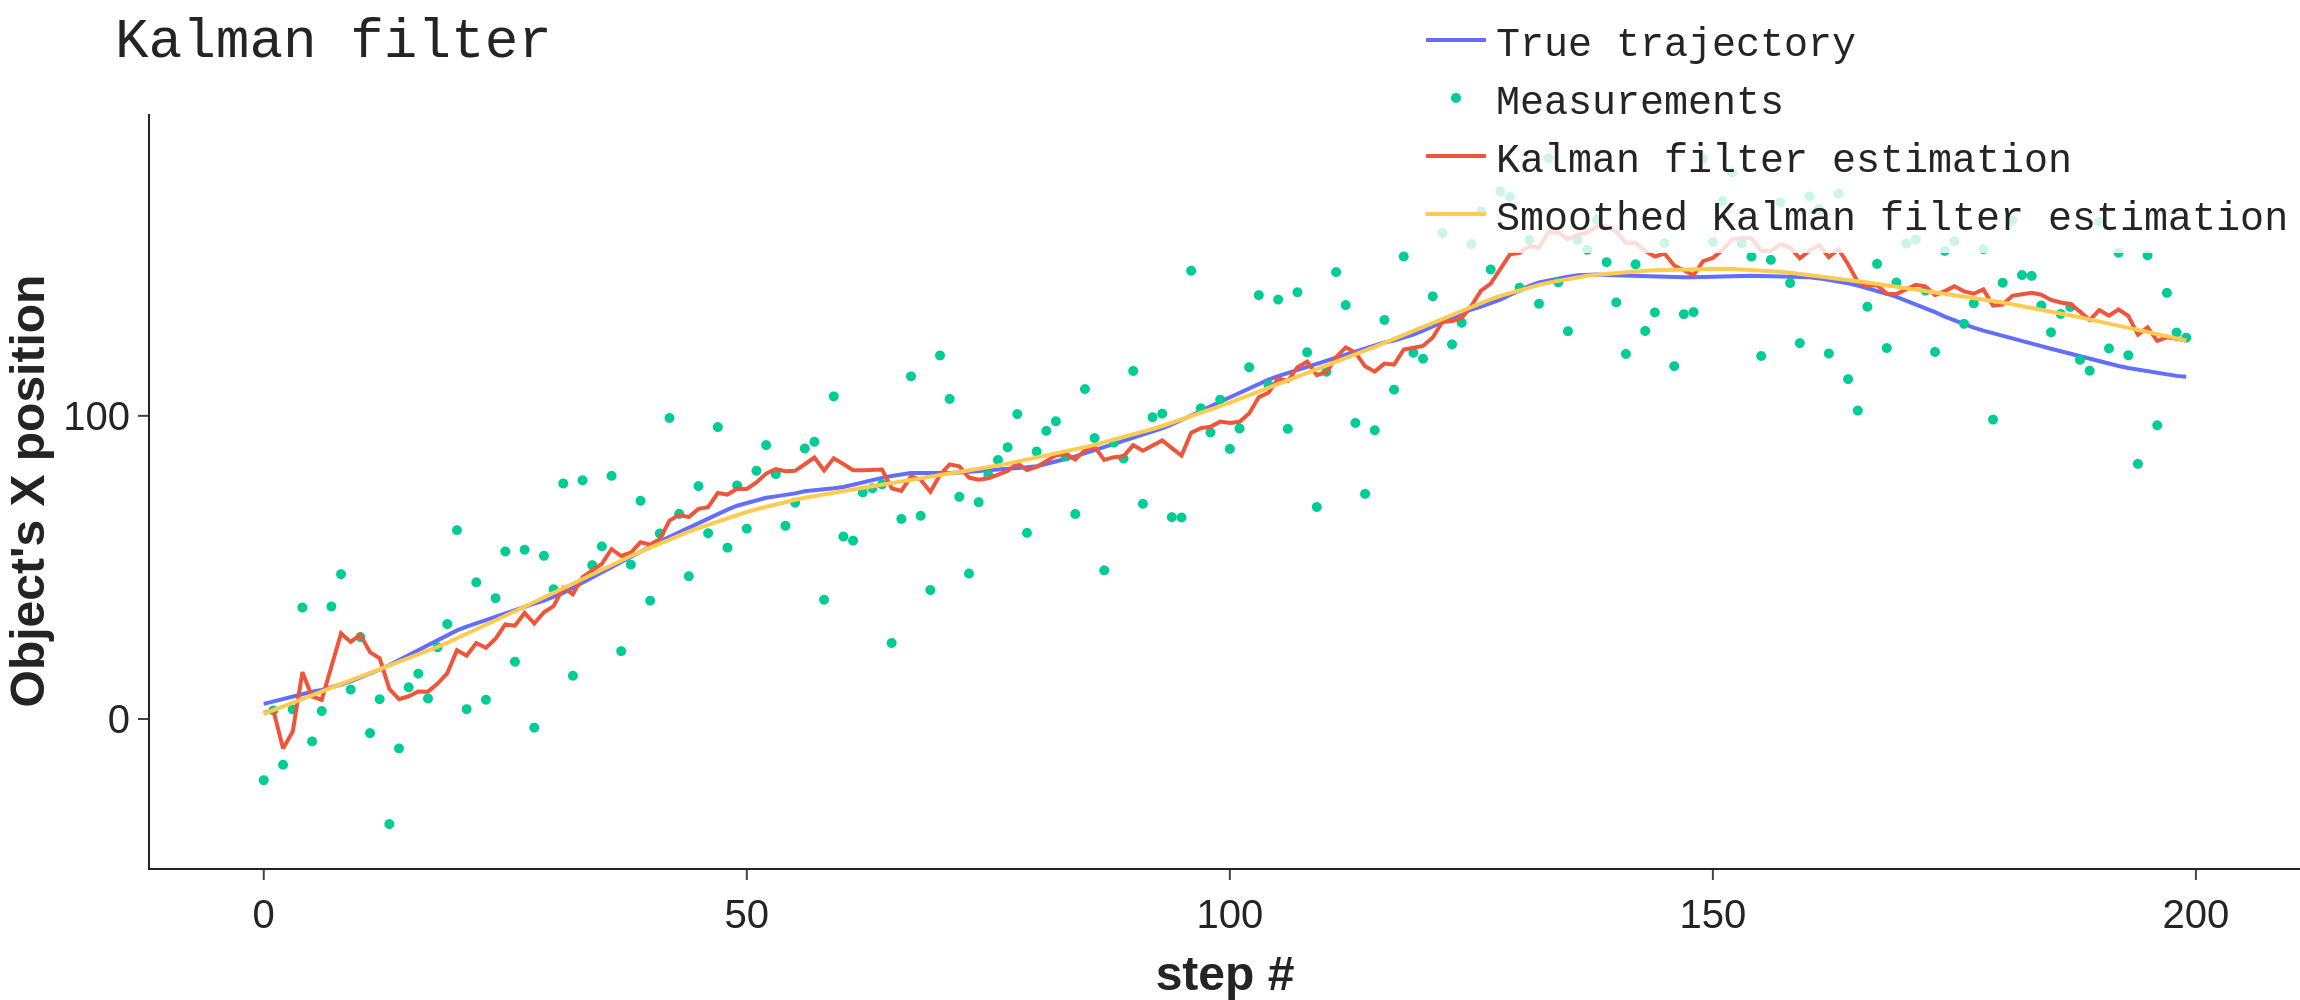

In [74]:
Image("Kalman_Filter.png")

Since we are moving backward in time, we use the last estimate of Kalman Filter as initial guess for smoothing, therefore they are the same. In contrast to filtering, smoothing produces signal with the reuced noise, and probably with smaller variance, however requires aposteriori filtered data.

In [45]:
def final_error(P0_0_diag, state_variance, Q_variance, sample_size: int = 200, M: int = 500, backward=False):
    #Initialization of matrices
    Error_true_filtered = np.zeros((2, 200))
    K_gain_sum = np.zeros((2, sample_size))
    P_diag_sum = np.zeros((2, sample_size))
    for i in range(M):
        # State vector and Kalman filter calculation
        X_vector = state_equation(sample_size = 200, X1 = 5, V1 = 1, T = 1, variance=state_variance)
        Z = measurement_equation(X=X_vector, meas_variance = 20**2)
        X_filtered, K_gain, P_diag = Kalman_filter(X=X_vector, Z=Z, sample_size=200, T=1, R=400, variance=Q_variance, m=7, P0_0_diag=P0_0_diag, backward=backward)
        # Error calculation
        Error_true_filtered += (X_vector - X_filtered) ** 2
        
        # Sum of filter gain K and diagonal elements of covariance matrix P
        K_gain_sum += K_gain
        P_diag_sum += np.sqrt(np.diagonal(P_diag, axis1=1, axis2=2)).T

    #Final error calculation over M runs
    RMSE_true_filtered = np.sqrt(Error_true_filtered / (M - 1))
    
    #Final mean calculation over M runs
    K_gain_mean = K_gain_sum / M
    P_diag_mean = P_diag_sum / M

    return RMSE_true_filtered, K_gain_mean, P_diag_mean

In [46]:
RMSE_true_filtered, K_gain_mean, P_diag_mean = final_error(10000, .04, .04)
RMSE_true_smoothed, K_gain_mean_smoothed, P_diag_mean_smoothed = final_error(10000, .04, .04, backward=True)

In [61]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = P_diag_mean[0, :], name = '\u03c3<sup>2</sup> of filtered position estimation', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = P_diag_mean_smoothed[0, :], name = '\u03c3<sup>2</sup> of smoothed position estimation', 
                         line_color = colors[9]))

fig.update_layout(title = 'Measurments` variance', xaxis_title='<b>step #</b>',yaxis_title = "<b>\u03c3<sup>2</sup></b>")
fig.show()
fig.write_image("pp_estimate.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

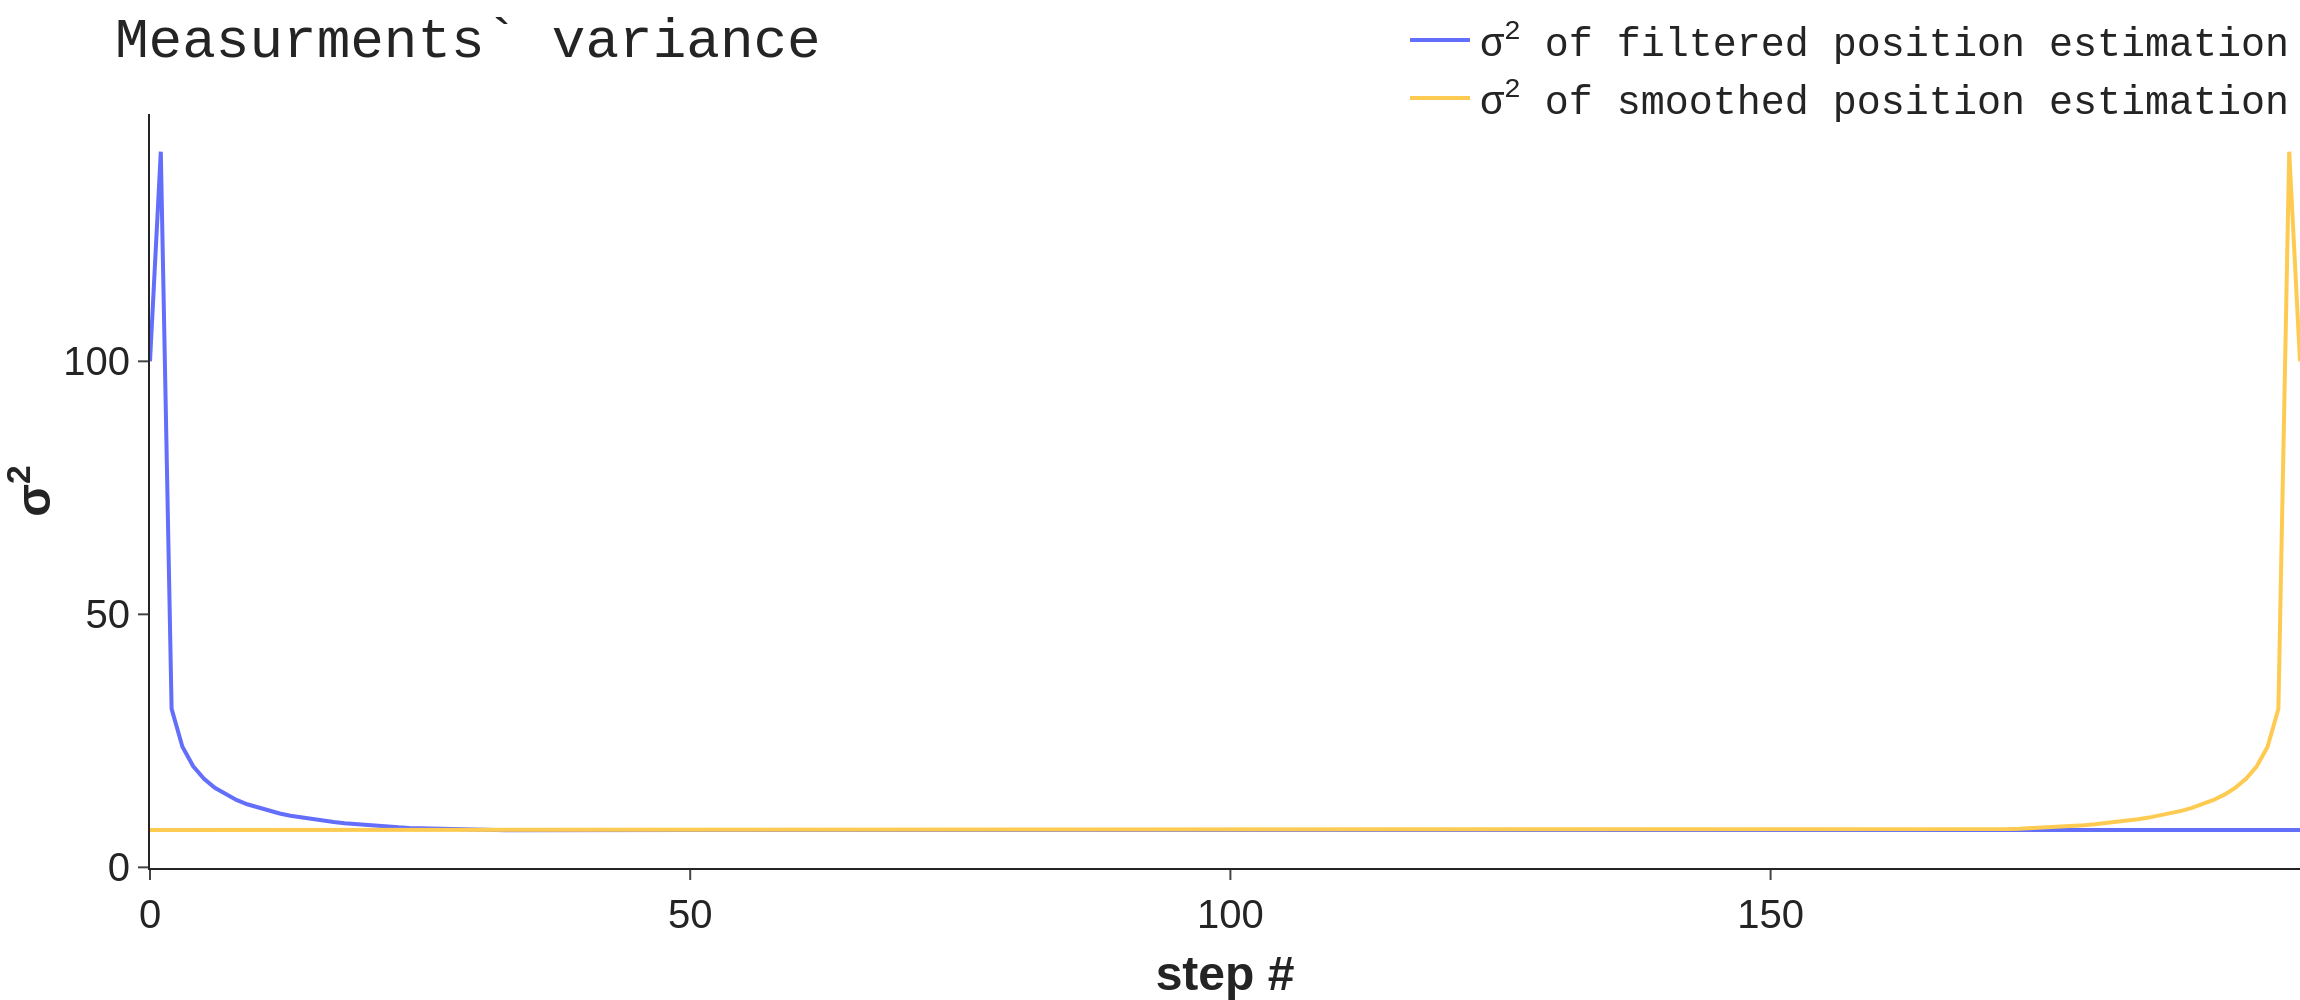

In [62]:
Image("pp_estimate.png")

In [63]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = P_diag_mean[1, :], name = '\u03c3<sup>2</sup> of filtered velocity estimation', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = P_diag_mean_smoothed[1, :], name = '\u03c3<sup>2</sup> of smoothed velocity estimation', 
                         line_color = colors[9]))

fig.update_layout(title = 'Measurments` variance', xaxis_title='<b>step #</b>',yaxis_title = "<b>\u03c3<sup>2</sup></b>")
fig.show()
fig.write_image("pv_estimate.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

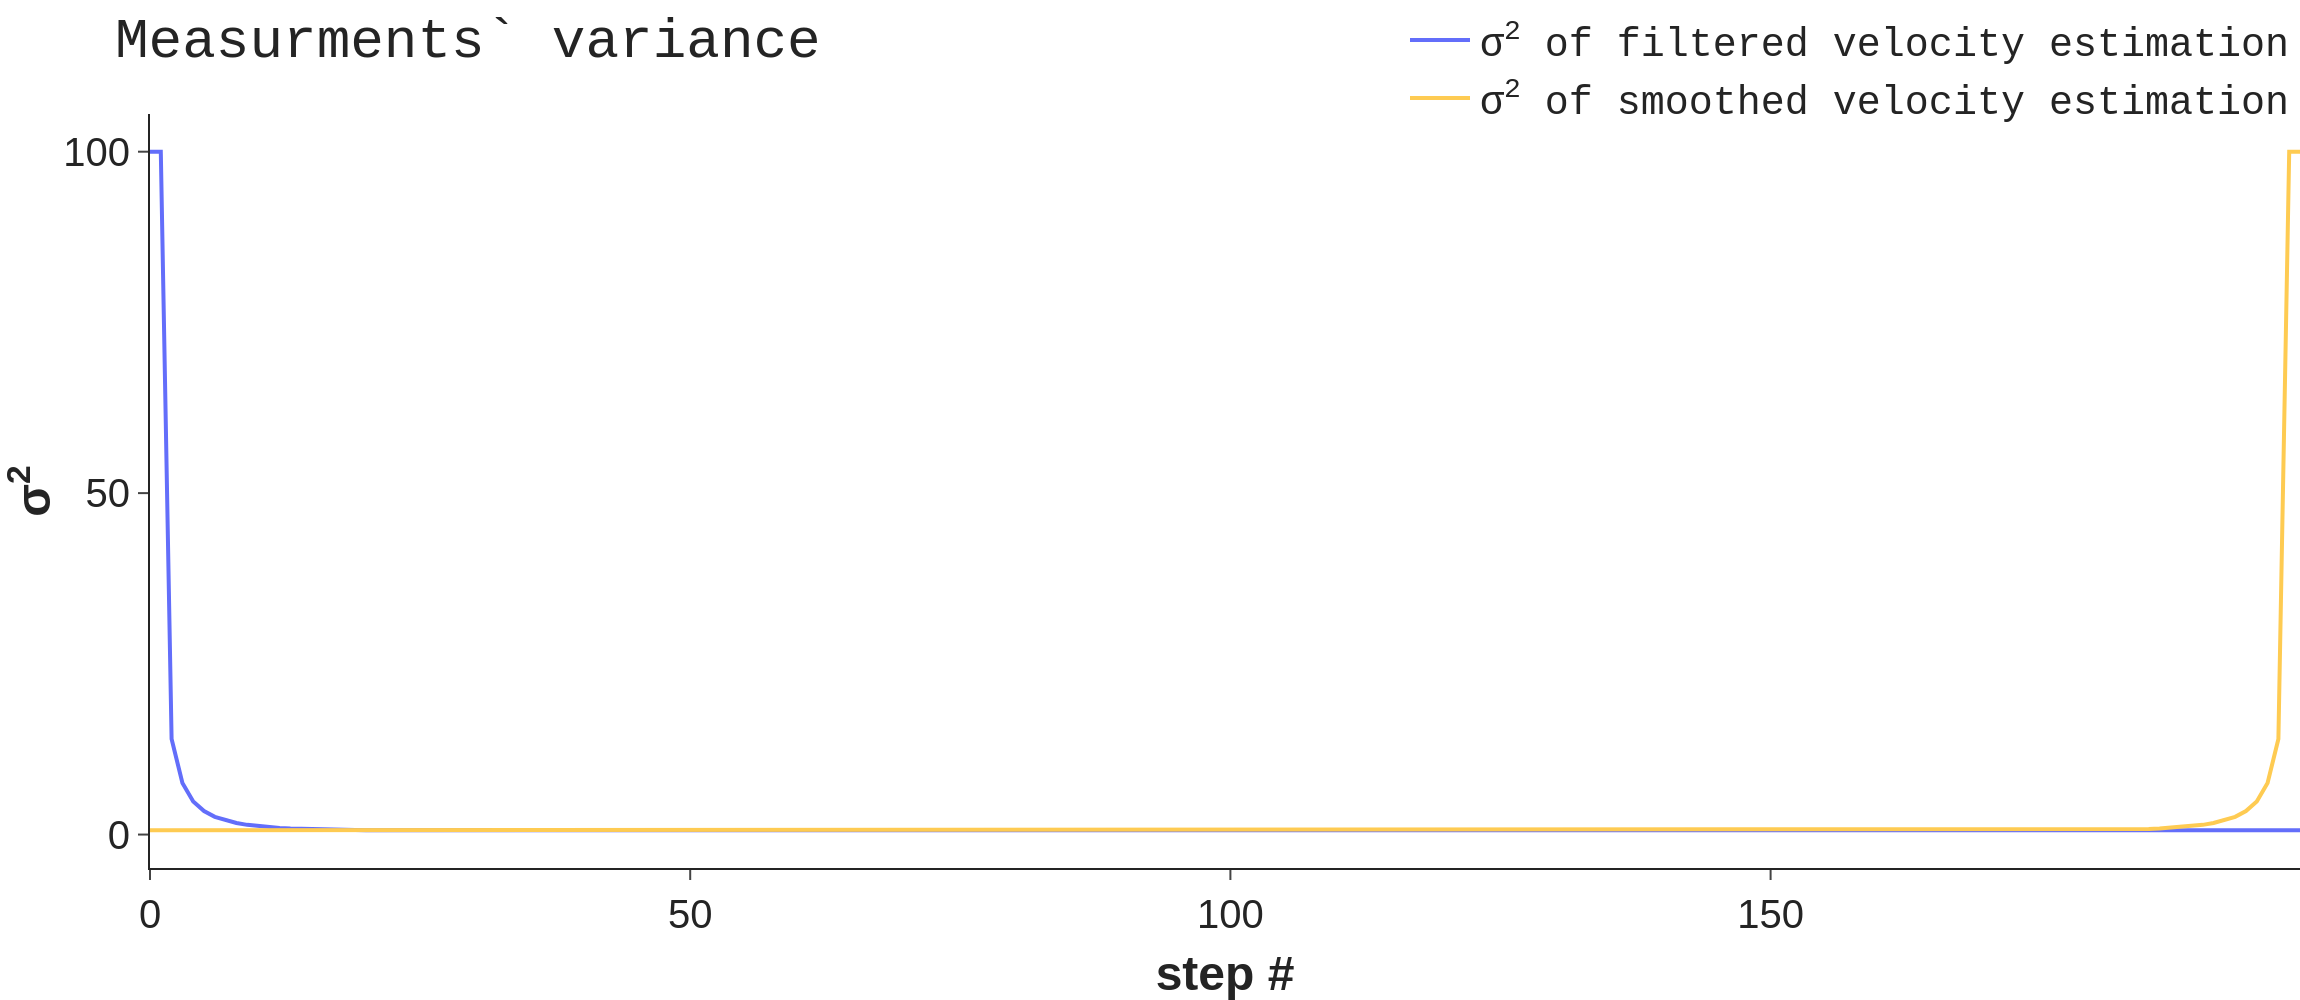

In [64]:
Image("pv_estimate.png")

In [69]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[0, :], name = 'RMSE of filtered position estimation', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = RMSE_true_smoothed[0, :], name = 'RMSE of smoothed position estimation', 
                         line_color = colors[9]))

fig.update_layout(title = 'Root mean squared error of filter', xaxis_title='<b>step #</b>',yaxis_title = "<b>\u03c3<sup>2</sup></b>")
fig.show()
fig.write_image("pos_estimate.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

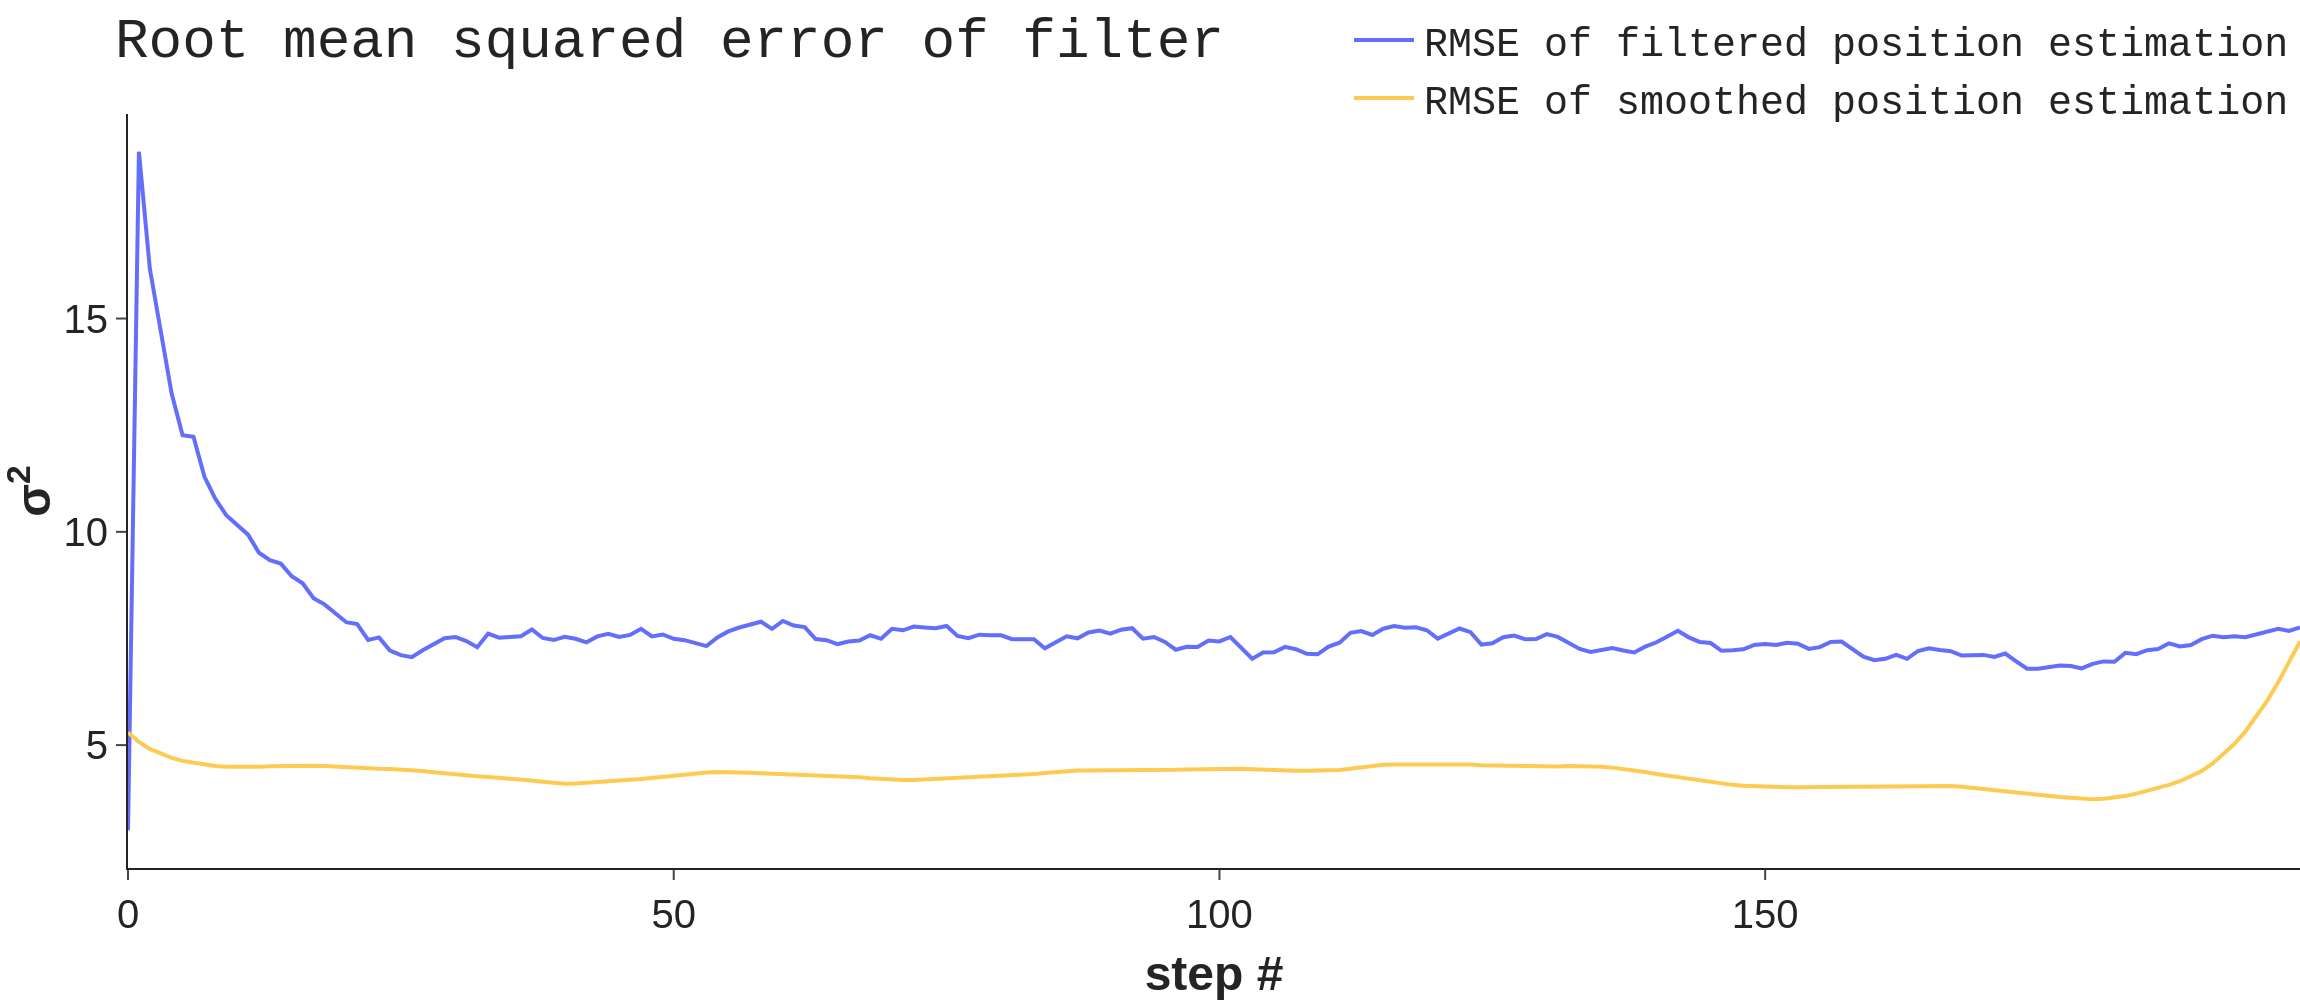

In [70]:
Image("pos_estimate.png")

As was discussed before, initial guess for backward smoothing is the final estimate, thus they match. As we can observe, error of smoothed signal is almost 2 times less.

In [71]:
fig = go.Figure()

sample_size = 200
x = np.arange(sample_size)

colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[1, :], name = 'RMSE of filtered velocity estimation', 
                         line_color = colors[0]))

fig.add_trace(go.Scatter(x = x, y = RMSE_true_smoothed[1, :], name = 'RMSE of smoothed velocity estimation', 
                         line_color = colors[9]))

fig.update_layout(title = 'Root mean squared error of filter', xaxis_title='<b>step #</b>',yaxis_title = "<b>\u03c3<sup>2</sup></b>")
fig.show()
fig.write_image("v_estimate.png", 
                format = 'png', width = 1150, height = 500, scale = 2)

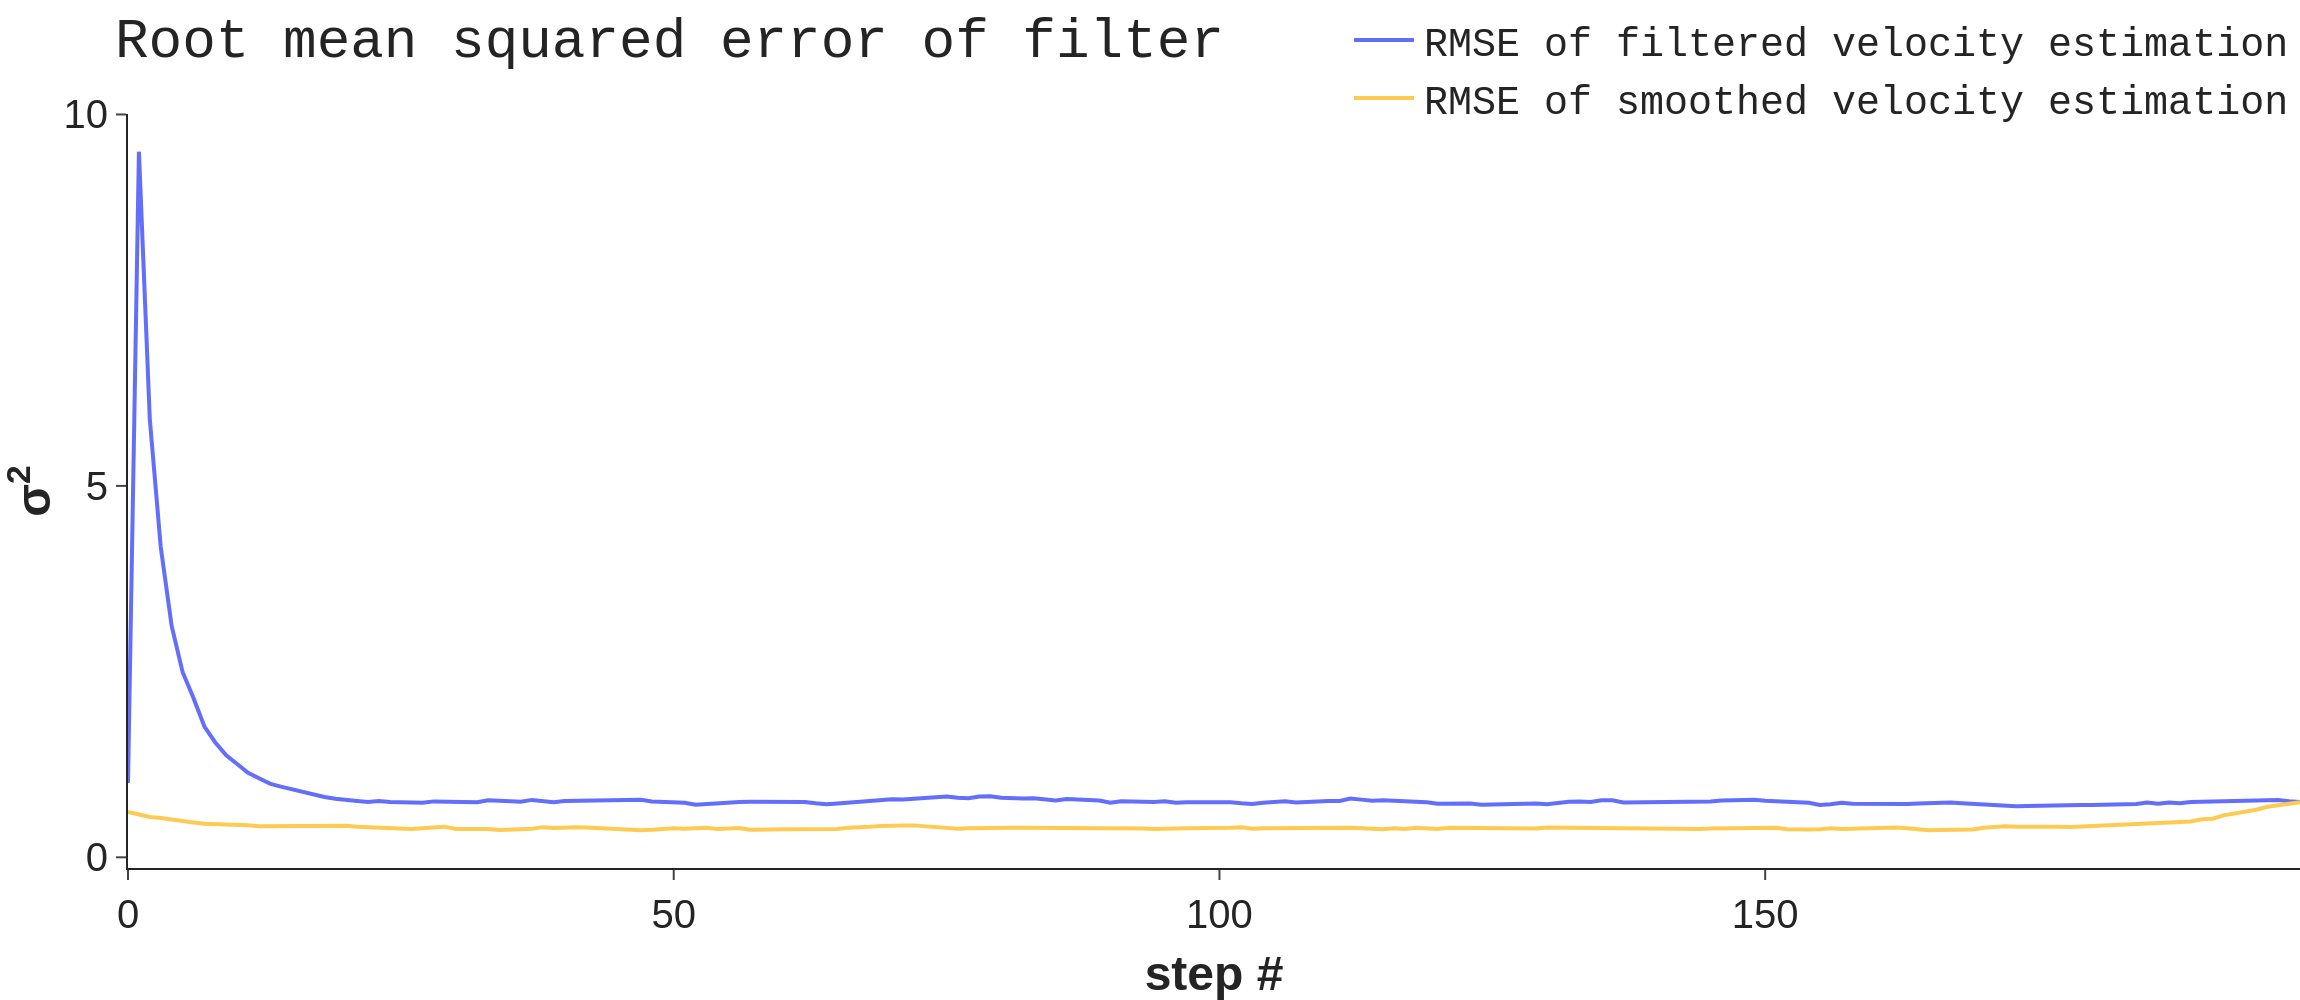

In [72]:
Image("v_estimate.png")

## Conclusion
All in all, backward smoothing turned out to be an effective noise reduction technique that decreased state noise almost in 2 times. Despite the main drawback - requirement of the posterior trajectory, backward smoothing still can be applied.<br>
After we ran procedure for 500 samples and calculated RMSE, we were, firstly, surprised of how smaller deviation became, and secondly, error increases on last steps, which is very natural for our algorithm.